<a href="https://colab.research.google.com/github/OluwajobaOluwabori/Customer-Churn-Prediction/blob/main/Capstone_Project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the dependencies





In [1]:
'''
Installing Apache Spark 3.3.24 with hadoop 3.0, Java 8 and Findspark in order to locate the spark in the system.
'''

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.4/spark-3.3.4-bin-hadoop3.tgz -O spark-3.3.4-bin-hadoop3.tgz
!tar -xvzf /content/spark-3.3.4-bin-hadoop3.tgz
!pip install -q findspark

'''
Setting the environment path that enables PySpark to run in this Colab environment.
'''

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.4-bin-hadoop3"

'''
Running a local spark session to test the installation.
'''

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

spark-3.3.4-bin-hadoop3/
spark-3.3.4-bin-hadoop3/R/
spark-3.3.4-bin-hadoop3/R/lib/
spark-3.3.4-bin-hadoop3/R/lib/sparkr.zip
spark-3.3.4-bin-hadoop3/R/lib/SparkR/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/worker/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/worker/worker.R
spark-3.3.4-bin-hadoop3/R/lib/SparkR/worker/daemon.R
spark-3.3.4-bin-hadoop3/R/lib/SparkR/tests/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/tests/testthat/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.3.4-bin-hadoop3/R/lib/SparkR/profile/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/profile/shell.R
spark-3.3.4-bin-hadoop3/R/lib/SparkR/profile/general.R
spark-3.3.4-bin-hadoop3/R/lib/SparkR/doc/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.3.4-bin-hadoop3/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.3.4-bin-hadoop3/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.3.4-bin-hadoop3/R/lib/SparkR/doc/index.html
spark-3.3.4-bin-hadoop3/R/lib/SparkR/R/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/R/SparkR
spark-

In [2]:
'''
Import libraries
'''

import pyspark.pandas as ps
from pyspark.sql import Window
from pyspark.sql.functions import udf,col,window, max as Fmax
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType,TimestampType
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,DecisionTreeClassifier
import numpy as np
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
import time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
from builtins import round




/content/spark-3.3.4-bin-hadoop3/python/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
# Creating a Spark session

spark = SparkSession \
    .builder \
    .appName("Churn Prediction") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()


TEXT PREPROCESSING

# **1. Load Data into Spark**

In [4]:
from pyspark import SparkFiles
from pyspark.sql import SparkSession
spark.sparkContext.addFile("https://udacity-dsnd.s3.amazonaws.com/sparkify/mini_sparkify_event_data.json")


data = spark.read.json("file://" +SparkFiles.get("mini_sparkify_event_data.json"))

In [5]:
data.show(30)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

# **Explore and Clean Data**

In [6]:
#data1.where(data1['_corrupt_record'].isNotNull()).show()

In [7]:
# Structure of the dataframe
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
#Column types
data.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [9]:
data.count()

286500

In [10]:
#Number of users
data.select('userId').distinct().count()

226

In [11]:
'''
 Rows with empty string in the 'userId' column correspond to logs in which user has not been logged in
 that is 'Logged Out' or 'Guest' authentication levels.
 '''

data.where(data['userId']=='').groupby('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



In [12]:
data.groupby('auth').count().show()
#data1.groupby('auth').count()



+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+



In [13]:
data.groupby('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 14457|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   924|
| Submit Registration|     5|
|            Settings|  1514|
|               Login|  3241|
|            Register|    18|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1726|
|             Upgrade|   499|
+--------------------+------+
only showing top 20 rows



In [14]:
#data.columns .groupby(['level','page']).count()['userId']
#data1[data1.page=='Submit Downgrade'].select('userId').pandas_api()
data=data.pandas_api()


#Distribution of pages users visited
data.page.value_counts().plot.bar()

In [15]:
data.page.value_counts()

NextSong                     228108
Home                          14457
Thumbs Up                     12551
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Login                          3241
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Help                           1726
Settings                       1514
About                           924
Upgrade                         499
Save Settings                   310
Error                           258
Submit Upgrade                  159
Submit Downgrade                 63
Cancel                           52
Cancellation Confirmation        52
Register                         18
Submit Registration               5
Name: page, dtype: int64

Notes

1. Only users with paid subscription can downgrade that is from 'premium' to 'free-tier'.
2. Any user regardless of their level(free or paid) can cancel their service.

Objective is to accurately identify these users before they leave so we can offer them discounts and incentives potentially saving the business millions in revenue

In [16]:
#How many users dropped off and what was the level of their account(free or paid)?

data[data.page=='Cancellation Confirmation'].groupby(['level','page']).count()['userId']

level  page                     
free   Cancellation Confirmation    21
paid   Cancellation Confirmation    31
Name: userId, dtype: int64

In [17]:
## Number of users that tried downgrading from paid to free and number of users that actually downgraded from paid to free

#Downgraded_users.userId.nunique()
#data[data.page=='Downgrade']['userId'].nunique()
print('{} users tried downgrading from paid to free and {} actually downgraded from paid to free.'.format(data[data.page=='Downgrade']['userId'].nunique(),data[data.page=='Submit Downgrade']['userId'].nunique()))

154 users tried downgrading from paid to free and 49 actually downgraded from paid to free.


In [18]:
#Let's take a look at the user-level information of premium users that actually downgraded their account

Downgraded_users = data[data['userId'].isin(data[data.page=='Submit Downgrade']['userId'].values)]
Downgraded_users.sort_values(by='userId')

/content/spark-3.3.4-bin-hadoop3/python/pyspark/pandas/generic.py:647: UserWarning:

We recommend using `Series.to_numpy()` instead.

/content/spark-3.3.4-bin-hadoop3/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.



,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
4582,Evanescence,Logged In,Colin,M,0,Larson,237.11302,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,256,Bring Me To Life,200,1538492662000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100
4591,Sheena Easton,Logged In,Colin,M,1,Larson,239.62077,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,256,Strut (1993 Digital Remaster),200,1538492899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100
4592,None,Logged In,Colin,M,2,Larson,NaN,paid,"Dallas-Fort Worth-Arlington, TX",PUT,Thumbs Down,1537982255000,256,None,307,1538492900000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100
4596,Moonbootica (w/IAMX),Logged In,Colin,M,3,Larson,407.27465,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,256,Pretty Little Angel,200,1538493138000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100
4607,tobyMac,Logged In,Colin,M,4,Larson,272.09098,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,256,City On Our Knees,200,1538493545000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100
4613,Fleetwood Mac,Logged In,Colin,M,5,Larson,167.83628,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,256,Monday Morning (LP Version),200,1538493817000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100
4621,Zero 7,Logged In,Colin,M,6,Larson,365.58322,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,256,Your Place [Album Version],200,1538493984000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100
4628,Young Dro (Featuring T.I.),Logged In,Colin,M,7,Larson,257.95873,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,256,Shoulder Lean [Featuring T.I.] (Amended Album ...,200,1538494349000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100
4630,None,Logged In,Colin,M,8,Larson,NaN,paid,"Dallas-Fort Worth-Arlington, TX",PUT,Add to Playlist,1537982255000,256,None,200,1538494374000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100
4634,Morning Runner,Logged In,Colin,M,9,Larson,260.85832,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,256,It's Not Like Everyones My Friend,200,1538494606000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100


# **Create Features**

In [19]:
#Convert a Pandas API on Spark Dataframe into a Spark DataFrame by using to_spark().
#It converts object from type pyspark.pandas.frame.DataFrame to pyspark.sql.dataframe.DataFrame

data=data.to_spark()


/content/spark-3.3.4-bin-hadoop3/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.



In [20]:
data = data.withColumn('date', timestamp_seconds(data.ts/1000))
#data1 = data1.withColumn('tsDate', (data1['ts'] / 1000).cast(TimestampType()))


## Define Churn

`Cancellation Confirmation` and `Submit Downgrade` events make up our definition for churn. `Cancellation Confirmation` happens for both paid and free users who cancel the services. `Submit Downgrade` happens for premium users who downgrades to free tier.

In [21]:
# Add the column 'churn' to identify users that churned. 1 for yes, 0 for no
df = data.withColumn('churn', when(data.page == 'Cancellation Confirmation',1).when(data.page == 'Submit Downgrade', 1).otherwise(0))
df = df.withColumn('user_churn', Fmax('churn').over(Window.partitionBy('UserId')))

In [22]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-----+----------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|               date|churn|user_churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-----+----------+
|         Evanescence|Logged In|    Colin|     M|            0|  Larson|237.11302| paid|Dallas-Fort Worth...|   PUT|       NextSong|1537982255000|      256|    Bring Me To Life|   200|1538492662000|Mozilla/5.

In [23]:
df.where(df.user_churn==0).show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-----+----------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|               date|churn|user_churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-----+----------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|1

In [24]:

df.filter(df.user_churn==1).select('userId').distinct().count()

92

In [26]:
data.filter((data.page=='Cancellation Confirmation' )| (data.page=='Submit Downgrade')).select('userId').distinct().count()

92

In [27]:
#features.filter(features.user_churn==1).select('userId').count()

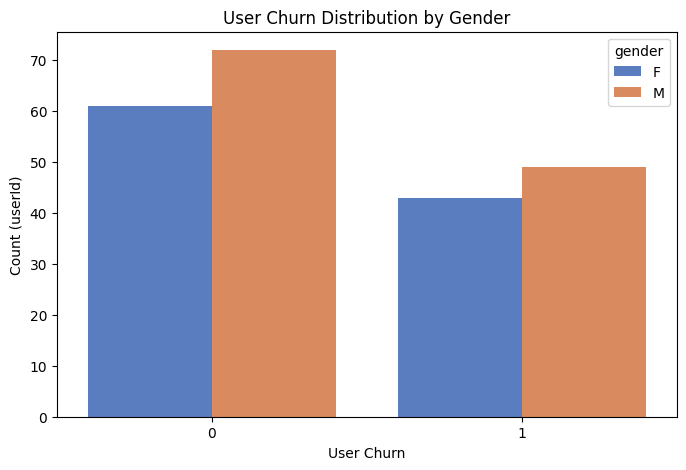

In [106]:
#Gender_churn = df.dropna(subset="gender").groupBy(["user_churn","gender"]).agg({"userId": "count"})
Gender_churn = df.select('gender','user_churn','userId').dropna(subset="gender").drop_duplicates().groupBy('gender','user_churn').count()
gender_churn = Gender_churn.toPandas()
plt.rcParams['figure.figsize'] = (8,5)

# Plotting the bar chart
#plt.figure(figsize=(8, 6))
sns.barplot(x='user_churn', y='count', hue='gender', data=gender_churn, palette='muted')
plt.title('User Churn Distribution by Gender')
plt.xlabel('User Churn')
plt.ylabel('Count (userId)')
plt.show()



In [104]:
colors = ["tealish green", "charcoal grey"]
palette = sns.xkcd_palette(colors)
df.select('gender','user_churn','userId').drop_duplicates().groupBy('gender','user_churn').count().show()

+------+----------+-----+
|gender|user_churn|count|
+------+----------+-----+
|     M|         1|   49|
|     F|         0|   61|
|     F|         1|   43|
|     M|         0|   72|
|  null|         0|    1|
+------+----------+-----+



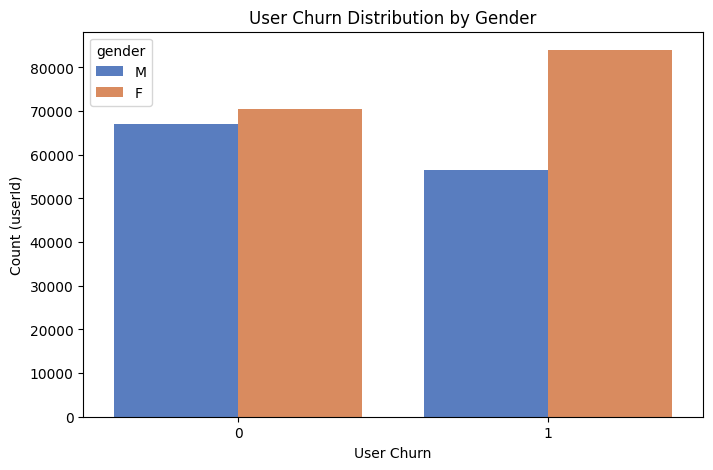

####Time between registration and drop-off(churn)

In [ ]:
#First 2 lines creates a dataframe with a new column for the difference in when user registered and the timestamp of that activity

life_time_df = df.groupby(['user_churn', 'userId', 'ts', 'registration']).count() \
                    .withColumn('life_time', (df.ts - df.registration) / 1000) \
                    .groupBy('userId', 'user_churn').agg({'life_time' : 'max'}).withColumnRenamed('max(life_time)','life_span')
#df.where(df.userId==105).tail(10)
life_time_df.show()
#life_time_df.where(life_time_df.user_churn==1).show()


+------+----------+-----------+
|userId|user_churn|  life_span|
+------+----------+-----------+
|   100|         1|  5605094.0|
|100004|         1|1.4898823E7|
|100005|         1|  7360899.0|
|100006|         1|   788587.0|
|100007|         1|  9969490.0|
|100008|         1|  5894948.0|
|100009|         1|  3234667.0|
|100010|         0|  4807612.0|
|100014|         1|  7351206.0|
|100015|         1|  5864764.0|
|100021|         1|  5593438.0|
|100022|         1|  4140310.0|
|100025|         1|  7673583.0|
|   101|         1|  4662657.0|
|   102|         0|  5588511.0|
|   104|         0|1.0850346E7|
|   107|         0|  6412544.0|
|    11|         1|1.0754921E7|
|   110|         0|  5908298.0|
|   112|         0|  7556771.0|
+------+----------+-----------+
only showing top 20 rows



In [ ]:
#flag_downgrade_event=udf(lambda x:1 if x=='Downgrade' else 0, IntegerType())
#Downgraded_users=Downgraded_users.withColumn('downgraded',flag_downgrade_event('page'))
Downgraded_users['downgraded']=Downgraded_users['page'].apply(lambda x:1 if x=='Submit Downgrade' else 0)

Downgraded_users['downgraded'].value_counts()

/content/spark-3.3.4-bin-hadoop3/python/pyspark/pandas/internal.py:1573: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/content/spark-3.3.4-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:486: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



0    106589
1        63
Name: downgraded, dtype: int64

In [ ]:
Downgraded_users = Downgraded_users.to_spark()

#spark method https://stackoverflow.com/questions/45946349/python-spark-cumulative-sum-by-group-using-dataframe
windowval = Window.partitionBy('userId').orderBy(['ts']).rangeBetween(Window.unboundedPreceding, 0)
Downgraded_users = Downgraded_users.withColumn('phase', f.sum('downgraded').over(windowval))

/content/spark-3.3.4-bin-hadoop3/python/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.



In [ ]:
#pandas method
#Downgraded_users = Downgraded_users.sort('ts', ascending=[False])#.reset_index(drop=True)
#Downgraded_users['phase'] = Downgraded_users.groupby('userId').cumsum()['downgraded'].show()


###Gender

In [ ]:
features = ps.DataFrame(dtype='int64')

gender = data.groupby('userId').agg(first(when(data['gender']=='M',0).otherwise(1))).withColumnRenamed('first(CASE WHEN (gender = M) THEN 0 ELSE 1 END)', 'gender')
features = gender
features.show()

/content/spark-3.3.4-bin-hadoop3/python/pyspark/pandas/internal.py:1573: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/content/spark-3.3.4-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:486: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



+------+------+
|userId|gender|
+------+------+
|   125|     0|
|    51|     0|
|   124|     1|
|     7|     0|
|    54|     1|
|    15|     0|
|   155|     1|
|   132|     1|
|   154|     1|
|   101|     0|
|    11|     1|
|   138|     0|
|    29|     0|
|    69|     1|
|    42|     1|
|   112|     0|
|    87|     0|
|    73|     1|
|    64|     0|
|     3|     0|
+------+------+
only showing top 20 rows



In [ ]:
features.filter(features.userId==100003).show()

+------+------+
|userId|gender|
+------+------+
|100003|     1|
+------+------+



###Number of songs each user listened to


In [ ]:
no_of_songsdf = data.where(Downgraded_users['page']== 'NextSong').groupby('userId').count()\
                .withColumnRenamed('count', 'songs')

features = features.join(no_of_songsdf, on = 'userId', how='left').withColumn('songs',when(col('songs').isNull(), 0).otherwise(col('songs')))


In [ ]:
features = features.join(life_time_df, on = 'userId')


In [ ]:
features.show()

+------+------+-----+----------+-----------+
|userId|gender|songs|user_churn|  life_span|
+------+------+-----+----------+-----------+
|   100|     0| 2682|         1|  5605094.0|
|100004|     1|  942|         1|1.4898823E7|
|100005|     0|  154|         1|  7360899.0|
|100006|     1|   26|         1|   788587.0|
|100007|     1|  423|         1|  9969490.0|
|100008|     1|  772|         1|  5894948.0|
|100009|     0|  518|         1|  3234667.0|
|100010|     1|  275|         0|  4807612.0|
|100014|     0|  257|         1|  7351206.0|
|100015|     1|  800|         1|  5864764.0|
|100021|     0|  230|         1|  5593438.0|
|100022|     1|  681|         1|  4140310.0|
|100025|     1|  490|         1|  7673583.0|
|   101|     0| 1797|         1|  4662657.0|
|   102|     0|  158|         0|  5588511.0|
|   104|     1| 1781|         0|1.0850346E7|
|   107|     1|  246|         0|  6412544.0|
|    11|     1|  647|         1|1.0754921E7|
|   110|     0|  178|         0|  5908298.0|
|   112|  

###Number of thumbs up and thumbs down given


In [ ]:
#Thumbs_Down = data1.withColumn('Thumbs Down',when(data1.page == 'Thumbs Down', 1).otherwise(0))
Thumbs_Down = data.groupBy('userId').agg(sum(when(data.page == 'Thumbs Down', 1).otherwise(0))).withColumnRenamed('sum(CASE WHEN (page = Thumbs Down) THEN 1 ELSE 0 END)','Thumbs Down')


#data1.filter(data1.page=='Thumbs Down').show()
Thumbs_Up = data.groupBy('userId').agg(sum(when(data.page == 'Thumbs Up', 1).otherwise(0))).withColumnRenamed('sum(CASE WHEN (page = Thumbs Up) THEN 1 ELSE 0 END)','Thumbs Up')


features = features.join(Thumbs_Down, on = 'userId')
features = features.join(Thumbs_Up, on = 'userId')

features.show()

+------+------+-----+----------+-----------+-----------+---------+
|userId|gender|songs|user_churn|  life_span|Thumbs Down|Thumbs Up|
+------+------+-----+----------+-----------+-----------+---------+
|   100|     0| 2682|         1|  5605094.0|         27|      148|
|100004|     1|  942|         1|1.4898823E7|         11|       35|
|100005|     0|  154|         1|  7360899.0|          3|        7|
|100006|     1|   26|         1|   788587.0|          2|        2|
|100007|     1|  423|         1|  9969490.0|          6|       19|
|100008|     1|  772|         1|  5894948.0|          6|       37|
|100009|     0|  518|         1|  3234667.0|          8|       23|
|100010|     1|  275|         0|  4807612.0|          5|       17|
|100014|     0|  257|         1|  7351206.0|          3|       17|
|100015|     1|  800|         1|  5864764.0|          8|       35|
|100021|     0|  230|         1|  5593438.0|          5|       11|
|100022|     1|  681|         1|  4140310.0|         20|      

####Level of User (free/paid)


In [ ]:
users_level = data.groupBy('userId').agg(first(when(data['level']=='free',0).otherwise(1)))\
.withColumnRenamed('first(CASE WHEN (level = free) THEN 0 ELSE 1 END)', 'level')\
.na.drop() #or .dropna()
features = features.join(users_level, on = 'userId')
features.show()


+------+------+-----+----------+-----------+-----------+---------+-----+
|userId|gender|songs|user_churn|  life_span|Thumbs Down|Thumbs Up|level|
+------+------+-----+----------+-----------+-----------+---------+-----+
|   100|     0| 2682|         1|  5605094.0|         27|      148|    1|
|100004|     1|  942|         1|1.4898823E7|         11|       35|    0|
|100005|     0|  154|         1|  7360899.0|          3|        7|    0|
|100006|     1|   26|         1|   788587.0|          2|        2|    0|
|100007|     1|  423|         1|  9969490.0|          6|       19|    1|
|100008|     1|  772|         1|  5894948.0|          6|       37|    1|
|100009|     0|  518|         1|  3234667.0|          8|       23|    0|
|100010|     1|  275|         0|  4807612.0|          5|       17|    0|
|100014|     0|  257|         1|  7351206.0|          3|       17|    1|
|100015|     1|  800|         1|  5864764.0|          8|       35|    0|
|100021|     0|  230|         1|  5593438.0|       

In [ ]:
data.select('location').distinct().show()


+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Kingsport-Bristol...|
|New Haven-Milford...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
|Allentown-Bethleh...|
|Miami-Fort Lauder...|
|           Selma, AL|
+--------------------+
only showing top 20 rows



In [ ]:
data.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|               date|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|
|    Five Ir

###Location of user

In [ ]:
#Split the location column into two new columns - City and State
data = data.withColumn('City',pyspark.sql.functions.split(data['location'], ',').getItem(0)).withColumn('State',pyspark.sql.functions.split(data['location'], ',').getItem(1))
indexer = StringIndexer(inputCol="State", outputCol="StateIndex", handleInvalid="skip")
data = indexer.fit(data).transform(data)
users_location = data.groupBy('userId').agg(last('StateIndex').alias('StateIndex')).na.drop() #or .dropna()
features = features.join(users_location, on = 'userId')
#features.show()

In [ ]:
data=data.drop('State')
#data.isnull('StateIndex')


In [ ]:
#location
data.groupby('userId').agg(countDistinct('location').alias('location_count')).sort('userId').show()


+------+--------------+
|userId|location_count|
+------+--------------+
|    10|             1|
|   100|             1|
|100001|             1|
|100002|             1|
|100003|             1|
|100004|             1|
|100005|             1|
|100006|             1|
|100007|             1|
|100008|             1|
|100009|             1|
|100010|             1|
|100011|             1|
|100012|             1|
|100013|             1|
|100014|             1|
|100015|             1|
|100016|             1|
|100017|             1|
|100018|             1|
+------+--------------+
only showing top 20 rows



/content/spark-3.3.4-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:248: FutureWarning:

Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead



<Axes: >

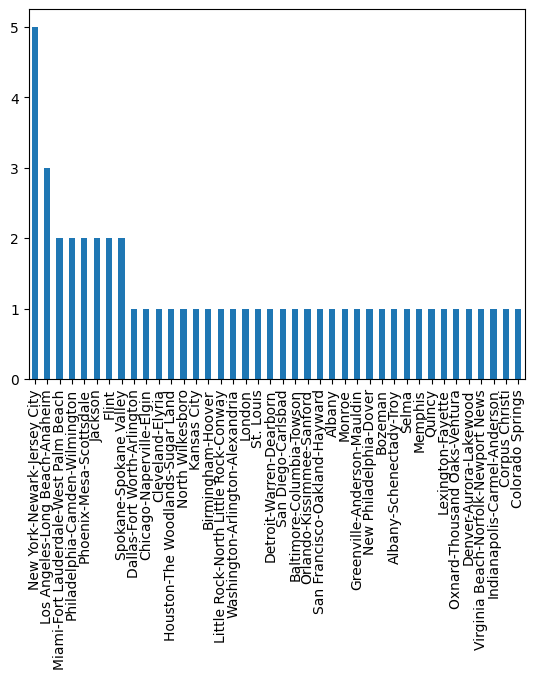

In [ ]:
#Number of churned users by state
#overall
state_df=data.filter(data.page=='Cancellation Confirmation').toPandas()['City'].value_counts()
state_df.plot.bar()


In [ ]:
data.filter(data.userId==103).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+--------------------+----------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|               date|                City|StateIndex|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+--------------------+----------+
|       Avril Lavigne|Logged In|    Piper|     F|            0| Nielsen|214.15138| free|New York-Newark-J...|   PUT|   NextSong|1537699856000|      102|               Alice|  

In [ ]:
#Users that churned, whats the proportion of free to paid users
#data1.filter(data1['page']=='Help').groupBy('level').count().show()
Visted_help_pg = data.filter(data.page=='Help')
#Help_count = Visted_help_pg.groupby('userId').agg(countDistinct('page').alias('Helps_count')).when(data1.Helps_count == null, 0).otherwise(data1.Helps_count)
Help_count = Visted_help_pg.groupby('userId').agg(countDistinct('page').alias('Help_count'))
features = features.join(Help_count, on = 'userId').withColumn('Help_count',(when(col(('Help_count')).isNull(), 0).otherwise(col(('Help_count')))))
features.show()

+------+------+-----+----------+-----------+-----------+---------+-----+----------+----------+
|userId|gender|songs|user_churn|  life_span|Thumbs Down|Thumbs Up|level|StateIndex|Help_count|
+------+------+-----+----------+-----------+-----------+---------+-----+----------+----------+
|   100|     0| 2682|         1|  5605094.0|         27|      148|    1|       2.0|         1|
|100004|     1|  942|         1|1.4898823E7|         11|       35|    0|      19.0|         1|
|100005|     0|  154|         1|  7360899.0|          3|        7|    0|      41.0|         1|
|100007|     1|  423|         1|  9969490.0|          6|       19|    1|      50.0|         1|
|100008|     1|  772|         1|  5894948.0|          6|       37|    1|       0.0|         1|
|100009|     0|  518|         1|  3234667.0|          8|       23|    0|       0.0|         1|
|100010|     1|  275|         0|  4807612.0|          5|       17|    0|      11.0|         1|
|100014|     0|  257|         1|  7351206.0|      

####Users' number of downgrade and upgrades


In [ ]:
Downgrade_No = data.groupBy('userId').agg(sum(when(data.page=='Submit Downgrade',1).otherwise(0)).alias('Downgrades'))
Upgrade_No = data.groupBy('userId').agg(sum(when(data.page=='Submit Upgrade',1).otherwise(0)).alias('Upgrades'))
features = features.join(Downgrade_No, on = 'userId')
features = features.join(Upgrade_No, on = 'userId')

features.show()

+------+------+-----+----------+-----------+-----------+---------+-----+----------+----------+----------+--------+
|userId|gender|songs|user_churn|  life_span|Thumbs Down|Thumbs Up|level|StateIndex|Help_count|Downgrades|Upgrades|
+------+------+-----+----------+-----------+-----------+---------+-----+----------+----------+----------+--------+
|   100|     0| 2682|         1|  5605094.0|         27|      148|    1|       2.0|         1|         1|       1|
|100004|     1|  942|         1|1.4898823E7|         11|       35|    0|      19.0|         1|         2|       3|
|100005|     0|  154|         1|  7360899.0|          3|        7|    0|      41.0|         1|         0|       0|
|100007|     1|  423|         1|  9969490.0|          6|       19|    1|      50.0|         1|         0|       0|
|100008|     1|  772|         1|  5894948.0|          6|       37|    1|       0.0|         1|         1|       0|
|100009|     0|  518|         1|  3234667.0|          8|       23|    0|       0

<ipython-input-49-01ec151bd055>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



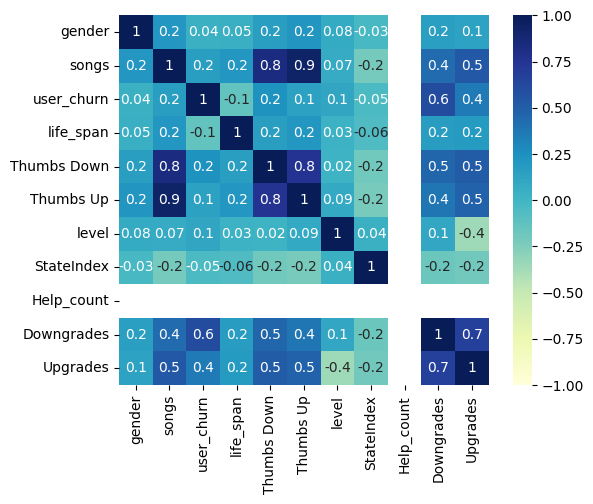

In [ ]:
#Correlation
features_df = features.toPandas()
corr_df = features_df.corr()
sns.heatmap(corr_df, cmap = "YlGnBu", square = True, vmin = -1, vmax = 1, annot=True,fmt='.1g');

#[['userId','gender','songs','user_churn','life_span','Thumbs Down','Thumbs Up','level', 'Help_count','Downgrades','Upgrades']]

In [ ]:
features.columns

['userId',
 'gender',
 'songs',
 'user_churn',
 'life_span',
 'Thumbs Down',
 'Thumbs Up',
 'level',
 'StateIndex',
 'Help_count',
 'Downgrades',
 'Upgrades']

In [ ]:
#Users that churned, whats the proportion of free to paid users
data.filter(data['page']=='Cancellation Confirmation').groupBy('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+



In [ ]:
data.filter(data['userId']==11).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+------------------+----------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|          page| registration|sessionId|                song|status|           ts|           userAgent|userId|               date|              City|StateIndex|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+------------------+----------+
|                null|Logged In|      Zoe|     F|            3|   Patel|     null| free|Providence-Warwic...|   GET|          Home|1532554781000|       10|                n

In [ ]:
data.select('page').distinct().show()#drop_duplicates

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



 In a distributed environment it can be a little more complicated to take raw DataFrames as an input for training so we would be using Assemblers to prepare our training data. VectorAssember from Spark ML library is a module that allows to convert numerical features into a single vector that is used by the machine learning models.

In [ ]:
assembler = VectorAssembler(
    inputCols=['songs','Thumbs Down','Thumbs Up','Help_count','Downgrades','Upgrades','life_span'],
    outputCol="features",handleInvalid = "keep" )
output_vector = assembler.transform(features)

scaler = StandardScaler(inputCol='features', outputCol ='num_vector_sc', withStd=True, withMean=True)
output_scaler = scaler.fit(output_vector).transform(output_vector)

final_assembler = VectorAssembler(inputCols=['num_vector_sc'] + ['gender','level'],outputCol='new_features')
final_vector = final_assembler.transform(output_scaler)
final_vector.show()


+------+------+-----+----------+-----------+-----------+---------+-----+----------+----------+----------+--------+--------------------+--------------------+--------------------+
|userId|gender|songs|user_churn|  life_span|Thumbs Down|Thumbs Up|level|StateIndex|Help_count|Downgrades|Upgrades|            features|       num_vector_sc|        new_features|
+------+------+-----+----------+-----------+-----------+---------+-----+----------+----------+----------+--------+--------------------+--------------------+--------------------+
|   100|     0| 2682|         1|  5605094.0|         27|      148|    1|       2.0|         1|         1|       1|[2682.0,27.0,148....|[1.34517860557145...|[1.34517860557145...|
|100004|     1|  942|         1|1.4898823E7|         11|       35|    0|      19.0|         1|         2|       3|[942.0,11.0,35.0,...|[-0.2005920608933...|[-0.2005920608933...|
|100005|     0|  154|         1|  7360899.0|          3|        7|    0|      41.0|         1|         0|     

In [ ]:
#final data
final_data = final_vector.select(final_vector.user_churn, final_vector.new_features)
final_data.show()

+----------+--------------------+
|user_churn|        new_features|
+----------+--------------------+
|         1|[1.34517860557145...|
|         1|[-0.2005920608933...|
|         1|[-0.9006307305337...|
|         1|[-0.6616581389940...|
|         1|[-0.3516156317548...|
|         1|[-0.5772626141008...|
|         0|[-0.7931374830381...|
|         1|[-0.8091282140705...|
|         1|[-0.3267411612600...|
|         1|[-0.4324576608630...|
|         1|[-0.6021370845956...|
|         1|[0.55896766314539...|
|         0|[0.54475368000548...|
|         1|[-0.4626623750353...|
|         0|[-0.8464399198128...|
|         0|[0.37063238654163...|
|         0|[1.07333617802075...|
|         0|[0.35819515129421...|
|         0|[2.58623700847452...|
|         0|[1.25189934121582...|
+----------+--------------------+
only showing top 20 rows



## **Build models**

In [ ]:
##Splitting final data into train and test dataset

train, test = final_data.randomSplit([0.8, 0.2], 42)

In [ ]:
# function for printing results
def evaluate_result(model_result, model_name, start, end):
    '''
    INPUT:
    model_result : result
    model_name : string
    start, end : training time start and end

    OUTPUT: list

    Description:
    The function return list of results and prints results and total time of the training

    '''

    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
    evaluator.setLabelCol('user_churn')
    accuracy = evaluator.evaluate(model_result, {evaluator.metricName : 'accuracy'})
    f1 = evaluator.evaluate(model_result, {evaluator.metricName : 'f1'})
    weightedPrecision = evaluator.evaluate(model_result, {evaluator.metricName : 'weightedPrecision'})
    weightedRecall = evaluator.evaluate(model_result, {evaluator.metricName : 'weightedRecall'})
    time = (end - start)/60
    result = [model_name, round(accuracy,3), round(f1,3), round(time,1)]

    print('{} performance metrics:'.format(model_name))
    print('Accuracy: {:.0%}'.format(accuracy))
    print('F-1 Score: {}'.format(f1))
    print('weightedPrecision: {}'.format(weightedPrecision))
    print('weightedRecall: {}'.format(weightedRecall))
    print('Total training time: {} minutes'.format(time))

    return result

In [ ]:
#function for printing metric results

def reports(model_result):
    '''
    INPUT:
    model_result : list

    OUTPUT: None

    Description:
    The function aggregate and prints results of models

    '''
    print(model_result[0])
    print('Accuracy: {}'.format(model_result[1]))
    print('F-1 Score: {}'.format(model_result[2]))
    print('Total training time: {} minutes'.format(model_result[3]))

    print()

In [ ]:
# start training
START = time.time()

##Logistics Regression

In [ ]:
numFolds = 3
lr = LogisticRegression(maxIter=10, labelCol='user_churn', featuresCol='new_features')
evaluator = MulticlassClassificationEvaluator(labelCol='user_churn')

pipeline = Pipeline(stages=[lr])
lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.1, 0.01, 0.001])
                .addGrid(lr.elasticNetParam, [0.1, 0.01, 0.5])
                .build())


crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=lr_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

lr_start = time.time()
lr_model = crossval.fit(train)
lr_end = time.time()


In [ ]:
lr_results = lr_model.transform(test)

lr_safe = evaluate_result(lr_results, 'Logistic Regression', lr_start, lr_end)

best_param = list(lr_model.getEstimatorParamMaps()[np.argmax(lr_model.avgMetrics)].values())
print('Best regression parameter(regParam) is {}, Best elasticNet parameter(elasticNetParam) is {}'.format(best_param[0],best_param[1]))

Logistic Regression performance metrics:
Accuracy: 0.75
F-1 Score: 0.7666666666666667
Total training time: 25.62712652683258 minutes
Best regression parameter(regParam) is 0.001, Best elasticNet parameter(elasticNetParam)


In [ ]:
lr_results = lr_model.transform(test)

lr_safe = evaluate_result(lr_results, 'Logistic Regression', lr_start, lr_end)

best_param = list(lr_model.getEstimatorParamMaps()[np.argmax(lr_model.avgMetrics)].values())
print('Best regression parameter(regParam) is {}, Best elasticNet parameter(elasticNetParam) is {}'.format(best_param[0],best_param[1]))

Logistic Regression performance metrics:
Accuracy: 91%
F-1 Score: 0.909148565086412
weightedPrecision: 0.9234693877551021
weightedRecall: 0.9142857142857144
Total training time: 20.175902156035104 minutes
Best regression parameter(regParam) is 0.001, Best elasticNet parameter(elasticNetParam) is 0.01


In [ ]:
lr_results.show()

+----------+--------------------+--------------------+--------------------+----------+
|user_churn|        new_features|       rawPrediction|         probability|prediction|
+----------+--------------------+--------------------+--------------------+----------+
|         1|[0.22138556357262...|[-5.5999750263594...|[0.00368433157047...|       1.0|
|         1|[0.28623686164844...|[3.78505688119431...|[0.97779661386326...|       0.0|
|         0|[-0.4688809926590...|[0.89871268234214...|[0.71068488662834...|       0.0|
|         1|[-0.5976952148644...|[-5.9517278867714...|[0.00259459238714...|       1.0|
+----------+--------------------+--------------------+--------------------+----------+



## Random Forest

In [ ]:
rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol='user_churn', featuresCol='new_features',seed=42,leafCol="leafId")
evaluator = MulticlassClassificationEvaluator(labelCol='user_churn')

pipeline = Pipeline(stages=[rf])
rf_paramGrid = (ParamGridBuilder()
                .addGrid(rf.numTrees, [2, 3, 4])
                .addGrid(rf.maxDepth, [2, 3, 4,5])
                .build())


crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=rf_paramGrid,
    evaluator=evaluator,
    numFolds=3)

rf_start = time.time()
rf_model = crossval.fit(train)
rf_end = time.time()


In [ ]:
rf_results = rf_model.transform(test)
rf_safe = evaluate_result(rf_results, 'Random Forest', rf_start, rf_end)

best_param = list(rf_model.getEstimatorParamMaps()[np.argmax(rf_model.avgMetrics)].values())
print('Best numTrees parameter is {}, Best maxDepth parameter is {}.'.format(best_param[0],best_param[1]))

Random Forest performance metrics:
Accuracy: 91%
F-1 Score: 0.9128704113224237
weightedPrecision: 0.9133089133089133
weightedRecall: 0.9142857142857143
Total training time: 16.961500136057534 minutes
Best numTrees parameter is 3, Best maxDepth parameter is 5.


In [ ]:
rf_results.show()

+----------+--------------------+--------------------+--------------------+----------+--------------+
|user_churn|        new_features|       rawPrediction|         probability|prediction|        leafId|
+----------+--------------------+--------------------+--------------------+----------+--------------+
|         0|[-0.8464399198128...|[2.78703703703703...|[0.92901234567901...|       0.0| [3.0,3.0,2.0]|
|         0|[-0.7931374830381...|[2.34087912087912...|[0.78029304029304...|       0.0| [0.0,9.0,0.0]|
|         0|[-0.5888114754020...|[2.83008658008658...|[0.94336219336219...|       0.0| [5.0,9.0,2.0]|
|         0|[-0.4671042447665...|[2.77188552188552...|[0.92396184062850...|       0.0| [5.0,3.0,2.0]|
|         0|[0.64513993593107...|[2.83008658008658...|[0.94336219336219...|       0.0| [5.0,9.0,2.0]|
|         0|[0.80149375047004...|[2.79040404040404...|[0.93013468013468...|       0.0| [5.0,5.0,2.0]|
|         1|[-0.8091282140705...|[2.78703703703703...|[0.92901234567901...|       

## Decision Tree

In [ ]:
numFolds = 3
dt = DecisionTreeClassifier(maxDepth=2,maxBins=32, labelCol='user_churn', featuresCol='new_features', leafCol="leafId")
evaluator = MulticlassClassificationEvaluator(labelCol='user_churn')

pipeline = Pipeline(stages=[dt])
dt_paramGrid = (ParamGridBuilder()
                .addGrid(rf.maxDepth, [2, 3, 4,5])
                .addGrid(rf.maxBins, [2, 10, 32])
                .build())


crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=dt_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

dt_start = time.time()
dt_model = crossval.fit(train)
dt_end = time.time()

In [ ]:
dt_results = dt_model.transform(test)
dt_safe = evaluate_result(dt_results, 'Decision Tree', dt_start, dt_end)

best_param = list(dt_model.getEstimatorParamMaps()[np.argmax(dt_model.avgMetrics)].values())
print(' Best maxDepth parameter is {}, Best maxBins parameter is {}.'.format(best_param[0],best_param[1]))

Decision Tree performance metrics:
Accuracy: 75%
F-1 Score: 0.7666666666666667
Total training time: 15.250719157854716 minutes
 Best maxDepth parameter is 2, Best maxBins parameter is 2.


In [ ]:
dt_results = dt_model.transform(test)
dt_safe = evaluate_result(dt_results, 'Decision Tree', dt_start, dt_end)

best_param = list(dt_model.getEstimatorParamMaps()[np.argmax(dt_model.avgMetrics)].values())
print(' Best maxDepth parameter is {}, Best maxBins parameter is {}.'.format(best_param[0],best_param[1]))

Decision Tree performance metrics:
Accuracy: 86%
F-1 Score: 0.8619003568124752
weightedPrecision: 0.8796203796203796
weightedRecall: 0.8571428571428571
Total training time: 15.283586525917054 minutes
 Best maxDepth parameter is 2, Best maxBins parameter is 2.


In [ ]:
columns=['Model','Accuracy score','F-1 Score','Total training time']
spark.createDataFrame([lr_safe,rf_safe,dt_safe],columns).show()


+-------------------+--------------+---------+-------------------+
|              Model|Accuracy score|F-1 Score|Total training time|
+-------------------+--------------+---------+-------------------+
|Logistic Regression|         0.914|    0.909|               20.2|
|      Random Forest|         0.914|    0.913|               17.0|
|      Decision Tree|         0.857|    0.862|               15.3|
+-------------------+--------------+---------+-------------------+



In [ ]:
def display_results(cv, y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\nBest Parameters:", cv.best_params_)


def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = build_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    display_results(model, y_test, y_pred)

In [ ]:
#How many churned went to 'help' also visited help before downgrading
#free or paid- level
#thumbs up
#thumbs down
#location
#last song and artist listened to
how many times did they click on downgrade before they submitted
users last subscription level
#no of downgrade and upgrades

Feature importances


In [ ]:
Downgraded_users.select('userId').show()

In [ ]:
def build_model():
    pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),

        ('clf', RandomForestClassifier())
    ])

    parameters = {
        'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'clf__n_estimators': [50, 100, 200],
        'clf__min_samples_split': [2, 3, 4]
    }

    cv = GridSearchCV(pipeline, param_grid=parameters)


# **Predict Churn**